<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "ANP"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/ANP/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


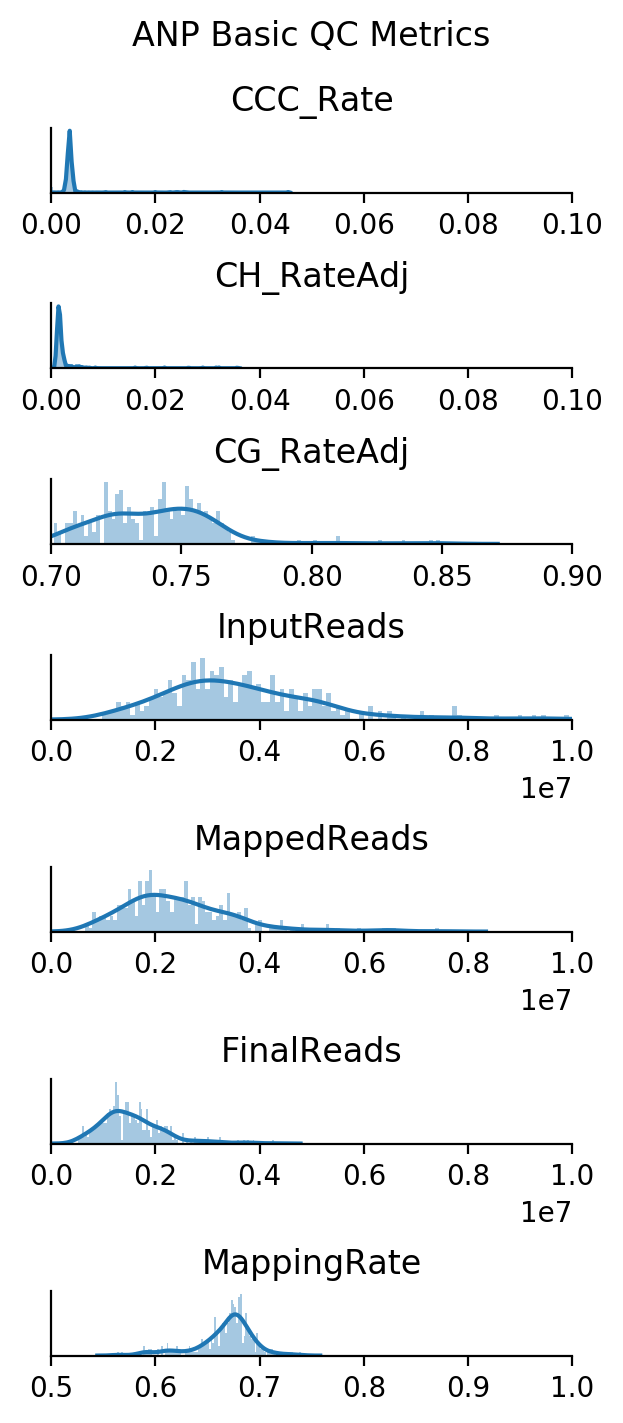

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

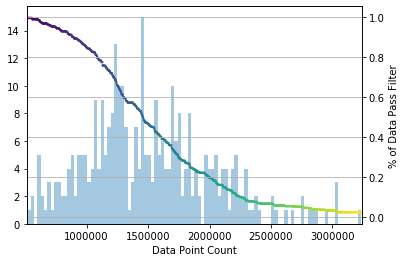

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 331/331 (100.0%)
CG_RateAdj passed 331/331 (100.0%)
CH_RateAdj passed 331/331 (100.0%)
FinalReads passed 331/331 (100.0%)
MappingRate passed 331/331 (100.0%)
Overall passed 331/331 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 4
171219 6
180109 6
180110 12
180111 5
180208 30
180212 33
180220 5
180222 11
180329 1
180402 1
180403 3
180405 3
180417 1
180424 1
180612 1
180911 4
180917 5
180925 7
181008 1
181009 3
181015 3
181016 7
181204 15
181206 20
181210 3
181218 2
190131 1
190205 2
190207 7
190212 22
190214 33
190219 22
190305 18
190625 7
190627 2
190711 15
190716 9


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 31 8.1%
ad002 43 11.2%
ad004 36 9.4%
ad006 51 13.3%
ad007 41 10.7%
ad008 33 8.6%
ad010 55 14.3%
ad012 41 10.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_122,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.003843,0.725228,0.724167,0.005406,0.001569,1961192.0,4950216,3245770.0,10E,...,-12.907785,5.883733,-30.836161,19.958678,ANP,-14.901747,-1.301600,40.256579,2.371593,True
10E_M_308,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.003876,0.729547,0.728495,0.005603,0.001733,1831834.0,4875492,3088300.0,10E,...,-12.945944,5.931602,-30.842900,20.002788,ANP,-14.775898,-1.204380,40.863201,2.311572,True
10F_M_194,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003709,0.727101,0.726085,0.005324,0.001621,1990244.0,5263918,3556855.0,10F,...,-13.012275,6.204220,-30.590947,19.916051,ANP,-15.226650,-1.569876,39.710798,1.848202,True
10F_M_2021,/gale/raidix/rdx-4/mapping/10F/CEMBA190627-10F...,0.003726,0.722501,0.721463,0.005313,0.001593,1155645.0,2785846,1879511.0,10F,...,-12.414544,5.027110,-32.272815,19.980107,ANP,-13.150635,-2.263021,45.578750,6.816501,True
10F_M_2304,/gale/raidix/rdx-4/mapping/10F/CEMBA190627-10F...,0.003432,0.729545,0.728613,0.004791,0.001364,2215376.0,5706706,3751543.0,10F,...,-13.000381,6.386413,-30.518789,19.877115,ANP,-15.255103,-1.565730,39.522592,1.917240,True
10F_M_610,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003741,0.739990,0.739014,0.005393,0.001659,1250767.0,3035936,2005245.0,10F,...,-12.759953,5.601119,-31.267022,20.017648,ANP,-14.352984,-1.462687,41.199725,4.150781,True
10F_M_727,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003583,0.702310,0.701240,0.005571,0.001995,1120651.0,2528854,1734489.0,10F,...,-12.961340,7.168913,-30.013326,19.590256,ANP,-15.600442,-2.063596,37.544873,1.772090,True
10F_M_753,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003418,0.732288,0.731370,0.004917,0.001505,1548021.0,3866238,2610734.0,10F,...,-12.840508,5.970579,-30.846939,19.915884,ANP,-14.464618,-1.546782,40.658600,4.012232,True
10F_M_770,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003435,0.749110,0.748245,0.004870,0.001441,2059119.0,5159562,3416895.0,10F,...,-13.036528,6.199171,-30.558873,19.939811,ANP,-14.909432,-1.235647,40.373033,1.927133,True
